# **EECE 608 - Final Project - Federated Learning in Medical Imaging**

BraTS 2020 dataset (brain tumor segmentation), which includes multiple MRI modalities per patient:


1. T1
2. T2
3. T1ce
4. FLAIR


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir -p /content/drive/MyDrive/EECE608

In [3]:
train_data = "/content/drive/MyDrive/EECE608/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
valid_data = "/content/drive/MyDrive/EECE608/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

In [4]:
! pip install nilearn
! pip install keras_unet_collection

In [5]:
!pip install keras_unet_collection nilearn nibabel opencv-python scikit-image
!pip install seaborn matplotlib pillow

#### Import Libraries

In [ ]:
import os, random, shutil, glob, warnings, tensorflow as tf, nibabel as nib, matplotlib.pyplot as plt, pandas as pd
np.set_printoptions(precision=3, suppress=True)
import cv2
import numpy.ma as ma
from PIL import Image, ImageOps
from skimage import data
import matplotlib.colors as mcolors
from skimage.util import montage
from skimage.transform import rotate, resize
import nibabel as nib
import nilearn as nl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate,
    Rescaling, Normalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
)
from tensorflow.keras.utils import plot_model
from keras_unet_collection import models, losses
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

 Visualizing patient: BraTS20_Training_106


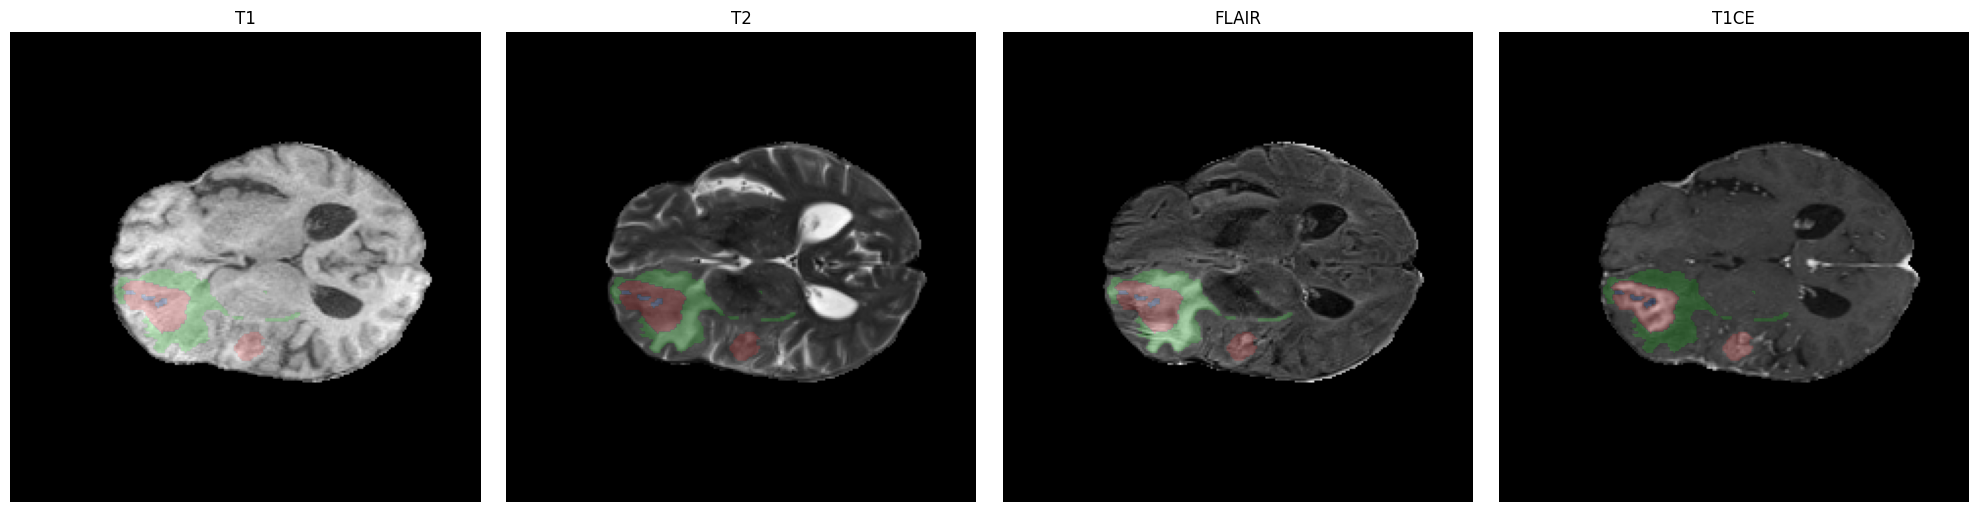

In [34]:
base_path = '/content/drive/MyDrive/EECE608/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_id = "BraTS20_Training_106"
modalities = ['t1', 't2', 'flair', 't1ce']
slice_idx = 75
print(" Visualizing patient:", patient_id)
images = {}
for modality in modalities:
    path = os.path.join(base_path, patient_id, f"{patient_id}_{modality}.nii")
    if os.path.exists(path):
        images[modality] = nib.load(path).get_fdata()
    else:
        print(f" {modality} not found!")

# Load segmentation
seg_path = os.path.join(base_path, patient_id, f"{patient_id}_seg.nii")
seg = nib.load(seg_path).get_fdata() if os.path.exists(seg_path) else None

# Mask color
label_colors = {
    1: (0.2, 0.4, 1.0, 0.4),   # Core (blue)
    2: (0.0, 1.0, 0.0, 0.4),   # Edema (green)
    4: (1.0, 0.0, 0.0, 0.4),   # Enhancing (red)
}

fig, axes = plt.subplots(1, len(modalities), figsize=(20, 5))
for i, modality in enumerate(modalities):
    ax = axes[i]
    ax.imshow(images[modality][:, :, slice_idx], cmap='gray')
    for label_value, color in label_colors.items():
        mask = seg[:, :, slice_idx] == label_value
        masked = ma.masked_where(~mask, mask)
        ax.imshow(masked, cmap=mcolors.ListedColormap([color]), alpha=color[3])
    ax.set_title(modality.upper())
    ax.axis('off')
plt.tight_layout()
plt.show()

Each patient have a single tumor that is segmented into three biologically distinct subregions rather than representing multiple tumors. These subregions include the necrotic or non-enhancing tumor core (labeled as 1), the surrounding edema or swelling (labeled as 2), and the enhancing tumor region that actively absorbs contrast agent (labeled as 3).

In [7]:
# Convert list of paths into list of IDs
def pathListIntoIDs(dir_list):
    return [path.split('/')[-1] for path in dir_list]


# Custom Data Generator class for Keras
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_ids, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_ids = list_ids
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.list_ids[k] for k in indexes]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        for c, case_id in enumerate(batch_ids):
            case_path = os.path.join(train_data, case_id)

            flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                idx = j + VOLUME_SLICES * c
                X[idx, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[idx, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], self.dim)
                y[idx] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, self.dim)
        return X / np.max(X), Y


# Split dataset into clients
def create_client(data, num_clients, initial='client'):
    client_names = [f'{initial}_{i + 1}' for i in range(num_clients)]
    size = len(data) // num_clients
    shards = [data[i:i + size] for i in range(0, len(data), size)]
    assert len(shards) == len(client_names)
    return {client_names[i]: shards[i] for i in range(len(client_names))}


# Weight utilities
def weight_scaling_factor(data):
    return len(data) / len(train_ids)


def scale_model_weights(weights, scalar):
    return [scalar * w for w in weights]


def sum_scaled_weights(scaled_weight_list):
    avg_grad = []
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad


# Model evaluation
def evaluate_model(data, model, round_num):
    test_generator = DataGenerator(data)
    results = model.evaluate(test_generator, batch_size=batch_size, verbose=1)
    loss, accuracy = results[0], results[1] * 100
    print(f'Round: {round_num} | Loss: {loss:.4f} | Accuracy: {accuracy:.2f}%')


In [8]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [26]:
# Load and filter directories
train_val_dirs = [f.path for f in os.scandir(train_data) if f.is_dir()]
train_val_dirs.remove(train_data + 'BraTS20_Training_355')  # Remove corrupted
# Utility: extract case IDs
def pathListIntoIDs(dirList):
    return [p.split('/')[-1] for p in dirList]
# Split dataset
ids = pathListIntoIDs(train_val_dirs)
train_test_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

Training set: will be used in clients
Validation set: For final evaluation

## **Data Preprocessing:**
1.   Load Slices from .nii files for each modality
2. Extract volumes
3. Resizing  128×128
4. One-hot encoding (4 segmentaion classes: no tumor, Necrotic / Non-enhancing tumor core, 	Peritumoral edema, 	Enhancing tumor)


## **Client Simulation (Federated Setup)**
1.   **client_1:** only gets flair images
2.   **client_2:** only t1ce images
3.   **client_3:** only t2 images

## **Loss Function:**
1.   **Dice Loss**
2.   **Categorical Cross-Entropy**


## **Trained on U-Net, U-Net 3+, and U-Net++**


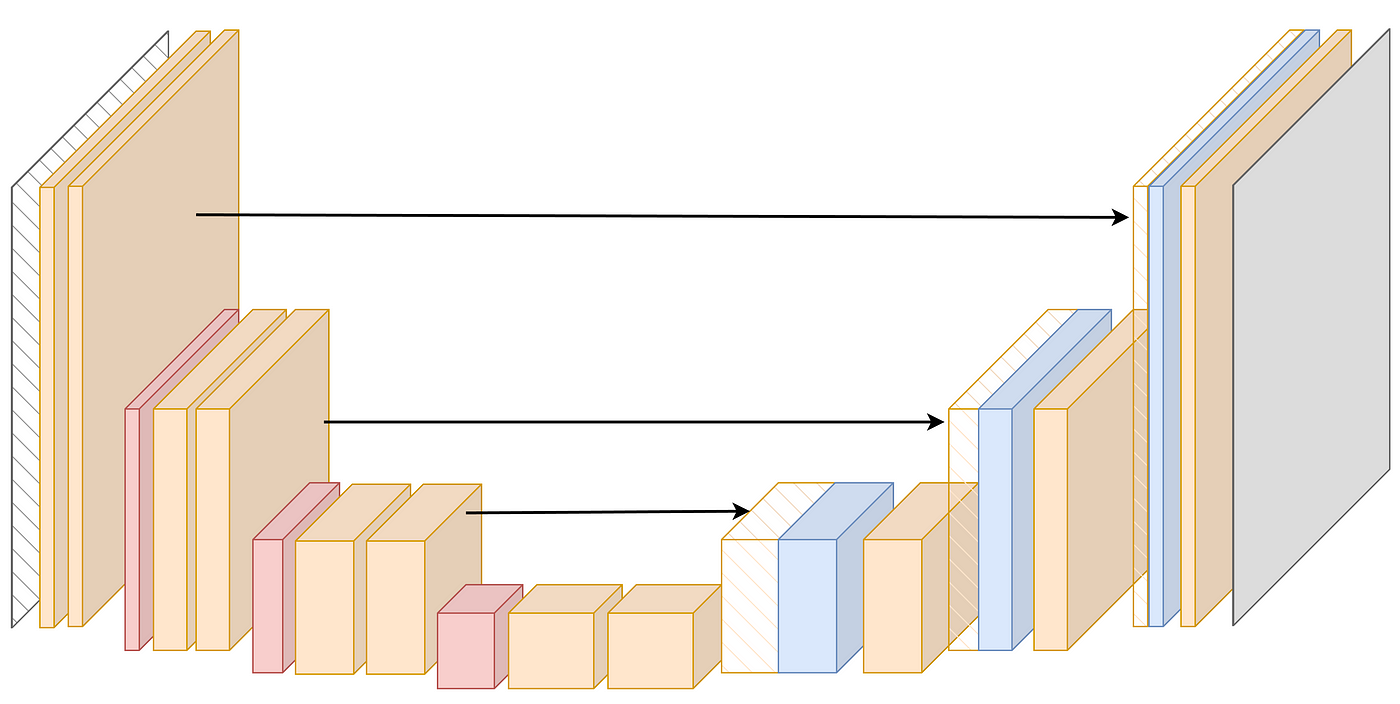

## **U-Net Pretrained Model**

In [38]:
tf.config.run_functions_eagerly(True)

IMG_SIZE = 128
VOLUME_SLICES = 20
VOLUME_START_AT = 22
BATCH_SIZE = 32
ROUNDS = 2
LEARNING_RATE = 0.0005

train_data = "/content/drive/MyDrive/EECE608/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
valid_data = "/content/drive/MyDrive/EECE608/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

# Load and split
def pathListIntoIDs(dirList): return [p.split('/')[-1] for p in dirList]
train_val_dirs = [f.path for f in os.scandir(train_data) if f.is_dir()]
train_val_dirs.remove(train_data + 'BraTS20_Training_355')
ids = pathListIntoIDs(train_val_dirs)
train_test_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# Data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, modality='flair', dim=(IMG_SIZE, IMG_SIZE), batch_size=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_ids = list_ids
        self.modality = modality
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.list_ids[k] for k in indexes]
        return self.__data_generation(batch_ids)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 1))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        for c, case_id in enumerate(batch_ids):
            case_path = os.path.join(train_data, case_id)
            image_path = os.path.join(case_path, f'{case_id}_{self.modality}.nii')
            image_vol = nib.load(image_path).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                idx = j + VOLUME_SLICES * c
                X[idx, :, :, 0] = cv2.resize(image_vol[:, :, j + VOLUME_START_AT], self.dim)
                y[idx] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3
        mask = tf.one_hot(y.astype(np.int32), depth=4)
        mask = tf.image.resize(mask, self.dim, method='nearest')
        X = X / (np.max(X) + 1e-8)
        return X, mask

# Client
def create_clients_by_modality(data_ids, modalities):
    size = len(data_ids) // len(modalities)
    shards = [data_ids[i * size:(i + 1) * size] for i in range(len(modalities))]
    return {f'client_{i+1}': (shards[i], modalities[i]) for i in range(len(modalities))}

clients = create_clients_by_modality(train_ids, modalities=['flair', 't1ce', 't2'])
valid_generator = DataGenerator(val_ids, modality='flair')

# Aggregation (FedAvg)
def weight_scaling_factor(data_gen): return len(data_gen) / len(train_ids)

def scale_model_weights(weights, scalar): return [scalar * w for w in weights]

def sum_scaled_weights(weight_list):
    avg_weights = []
    for weights in zip(*weight_list):
        avg_weights.append(tf.reduce_sum(weights, axis=0))
    return avg_weights

def evaluate_model(data_ids, model, round_num):
    val_gen = DataGenerator(data_ids, modality='flair')
    results = model.evaluate(val_gen, batch_size=BATCH_SIZE, verbose=1)
    print(f" Round {round_num} | Loss: {results[0]:.4f} | Accuracy: {results[1]*100:.2f}% | Dice: {results[2]:.4f}")

# Loss and metrics (dice and crossentropy)
loss_fn = lambda y_true, y_pred: losses.dice(y_true, y_pred) + tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)

# Global model
global_model = models.unet_2d((IMG_SIZE, IMG_SIZE, 1), [32, 64, 128, 256, 512], 4, activation='Softmax')
global_model.compile(loss=loss_fn, optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy', losses.dice])

print("\n Begin Federated Training")

# FL Loop (2 rounds)
for round_num in range(1, ROUNDS + 1):
    print(f"\n Round {round_num}")
    global_weights = global_model.get_weights()
    scaled_weights_list = []

    for name, (ids_subset, modality) in clients.items():
        print(f"\n Training {name} on modality: {modality}")
        local_model = models.unet_2d((IMG_SIZE, IMG_SIZE, 1), [32, 64, 128, 256, 512], 4, activation='Softmax')
        local_model.compile(loss=loss_fn, optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy', losses.dice])
        local_model.set_weights(global_weights)

        data_gen = DataGenerator(ids_subset, modality=modality)
        local_model.fit(data_gen, epochs=2, steps_per_epoch=len(data_gen), verbose=1)

        scale = weight_scaling_factor(data_gen)
        scaled_weights = scale_model_weights(local_model.get_weights(), scale)
        scaled_weights_list.append(scaled_weights)

        K.clear_session()

    new_weights = sum_scaled_weights(scaled_weights_list)
    global_model.set_weights(new_weights)
    evaluate_model(test_ids, global_model, round_num)

print("\n Federated Training Complete!")

# Save model
global_model.save("/content/drive/MyDrive/EECE608/final_federated_unet_model.keras")



 Begin Federated Training

 Round 1

 Training client_1 on modality: flair
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 47s 557ms/step - accuracy: 0.4780 - dice: 0.7350 - loss: 2.0640
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 602ms/step - accuracy: 0.9988 - dice: 0.6794 - loss: 1.8180

 Training client_2 on modality: t1ce
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 47s 561ms/step - accuracy: 0.4773 - dice: 0.7350 - loss: 2.0642
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 613ms/step - accuracy: 0.9977 - dice: 0.6795 - loss: 1.8184

 Training client_3 on modality: t2
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 599ms/step - accuracy: 0.4770 - dice: 0.7351 - loss: 2.0642
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 641ms/step - accuracy: 0.9966 - dice: 0.6796 - loss: 1.8189
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 325ms/step - accuracy: 0.9969 - dice: 0.6328 - loss: 1.6349
 Round 1 | Loss: 1.6341 | Accuracy: 99.81% | Dice: 0.6326

 Round 2

 Training client_1 on modality: flair
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 590ms

In [39]:
# Per modality performance
def evaluate_model_on_all_modalities(data_ids, model):
    print("\n Final Evaluation on Test Set Across Modalities:")
    for modality in ['flair', 't1ce', 't2']:
        test_gen = DataGenerator(data_ids, modality=modality)
        results = model.evaluate(test_gen, batch_size=BATCH_SIZE, verbose=1)
        print(f" Modality: {modality.upper()} | Loss: {results[0]:.4f} | Accuracy: {results[1]*100:.2f}% | Dice: {results[2]:.4f}")
evaluate_model_on_all_modalities(test_ids, global_model)



 Final Evaluation on Test Set Across Modalities:
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - accuracy: 0.9980 - dice: 0.5143 - loss: 1.2374
 Modality: FLAIR | Loss: 1.2373 | Accuracy: 99.81% | Dice: 0.5143
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 294ms/step - accuracy: 0.9978 - dice: 0.5144 - loss: 1.2377
 Modality: T1CE | Loss: 1.2373 | Accuracy: 99.81% | Dice: 0.5143
45/45 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9979 - dice: 0.5143 - loss: 1.2375
 Modality: T2 | Loss: 1.2373 | Accuracy: 99.81% | Dice: 0.5143


In [40]:
# Evalutaion (on combined modalities)
def create_combined_test_generator(test_ids, modalities):
    all_X = []
    all_Y = []

    for modality in modalities:
        gen = DataGenerator(test_ids, modality=modality, shuffle=False)
        X, Y = [], []
        for i in range(len(gen)):
            x_batch, y_batch = gen[i]
            X.append(x_batch)
            Y.append(y_batch)
        all_X.append(np.concatenate(X, axis=0))
        all_Y.append(np.concatenate(Y, axis=0))
    final_X = np.concatenate(all_X, axis=0)
    final_Y = np.concatenate(all_Y, axis=0)

    return final_X, final_Y
modalities = ['flair', 't1ce', 't2']
X_test, Y_test = create_combined_test_generator(test_ids, modalities)

print("\n Final Evaluation on Combined Test Data (All Modalities)")
global_model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=1)


 Final Evaluation on Combined Test Data (All Modalities)
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9985 - dice: 0.5142 - loss: 1.2367


[1.2372599840164185, 0.9980998635292053, 0.5143372416496277]

----------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Using U-Net++**

In [41]:
tf.config.run_functions_eagerly(True)
IMG_SIZE = 128
VOLUME_SLICES = 20
VOLUME_START_AT = 22
BATCH_SIZE = 32
ROUNDS = 2
LEARNING_RATE = 0.0005

train_data = "/content/drive/MyDrive/EECE608/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
valid_data = "/content/drive/MyDrive/EECE608/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

# -Load and Split
def pathListIntoIDs(dirList): return [p.split('/')[-1] for p in dirList]
train_val_dirs = [f.path for f in os.scandir(train_data) if f.is_dir()]
train_val_dirs.remove(train_data + 'BraTS20_Training_355')
ids = pathListIntoIDs(train_val_dirs)
train_test_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# ----- DATA GENERATOR -----
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, modality='flair', dim=(IMG_SIZE, IMG_SIZE), batch_size=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_ids = list_ids
        self.modality = modality
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.list_ids[k] for k in indexes]
        return self.__data_generation(batch_ids)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 1))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        for c, case_id in enumerate(batch_ids):
            case_path = os.path.join(train_data, case_id)
            image_path = os.path.join(case_path, f'{case_id}_{self.modality}.nii')
            image_vol = nib.load(image_path).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()
            for j in range(VOLUME_SLICES):
                idx = j + VOLUME_SLICES * c
                X[idx, :, :, 0] = cv2.resize(image_vol[:, :, j + VOLUME_START_AT], self.dim)
                y[idx] = seg[:, :, j + VOLUME_START_AT]
        y[y == 4] = 3
        mask = tf.one_hot(y.astype(np.int32), depth=4)
        mask = tf.image.resize(mask, self.dim, method='nearest')
        X = X / (np.max(X) + 1e-8)
        return X, mask

# Client
def create_clients_by_modality(data_ids, modalities):
    size = len(data_ids) // len(modalities)
    shards = [data_ids[i * size:(i + 1) * size] for i in range(len(modalities))]
    return {f'client_{i+1}': (shards[i], modalities[i]) for i in range(len(modalities))}

clients = create_clients_by_modality(train_ids, modalities=['flair', 't1ce', 't2'])
# Utilities (FedAvg, etc.)
def weight_scaling_factor(data_gen): return len(data_gen) / len(train_ids)
def scale_model_weights(weights, scalar): return [scalar * w for w in weights]
def sum_scaled_weights(weight_list):
    avg_weights = []
    for weights in zip(*weight_list):
        avg_weights.append(tf.reduce_sum(weights, axis=0))
    return avg_weights

def evaluate_model(data_ids, model, round_num):
    val_gen = DataGenerator(data_ids, modality='flair')  # fixed modality for now
    results = model.evaluate(val_gen, batch_size=BATCH_SIZE, verbose=1)
    print(f" Round {round_num} | Loss: {results[0]:.4f} | Accuracy: {results[1]*100:.2f}% | Dice: {results[2]:.4f}")

# Loss and Metrics
loss_fn = lambda y_true, y_pred: losses.dice(y_true, y_pred) + tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)

# U-Net++
global_model = models.unet_plus_2d((IMG_SIZE, IMG_SIZE, 1), [32, 64, 128, 256, 512], 4, activation='Softmax')
global_model.compile(loss=loss_fn, optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy', losses.dice])

print("\n Begin Federated Training")

# FL Loop
for round_num in range(1, ROUNDS + 1):
    print(f"\n Round {round_num}")
    global_weights = global_model.get_weights()
    scaled_weights_list = []

    for name, (ids_subset, modality) in clients.items():
        print(f"\n Training {name} on modality: {modality}")
        local_model = models.unet_plus_2d((IMG_SIZE, IMG_SIZE, 1), [32, 64, 128, 256, 512], 4, activation='Softmax')
        local_model.compile(loss=loss_fn, optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy', losses.dice])
        local_model.set_weights(global_weights)

        data_gen = DataGenerator(ids_subset, modality=modality)
        local_model.fit(data_gen, epochs=2, steps_per_epoch=len(data_gen), verbose=1)

        scale = weight_scaling_factor(data_gen)
        scaled_weights = scale_model_weights(local_model.get_weights(), scale)
        scaled_weights_list.append(scaled_weights)

        K.clear_session()

    new_weights = sum_scaled_weights(scaled_weights_list)
    global_model.set_weights(new_weights)
    evaluate_model(test_ids, global_model, round_num)

print("\n Federated Training Complete!")

# Save model
global_model.save("/content/drive/MyDrive/EECE608/final_federated_unet_plus_model.keras")


 Begin Federated Training

 Round 1

 Training client_1 on modality: flair
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 637ms/step - accuracy: 0.3591 - dice: 0.7497 - loss: 2.1355
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 601ms/step - accuracy: 0.9988 - dice: 0.6981 - loss: 1.8969

 Training client_2 on modality: t1ce
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 514ms/step - accuracy: 0.3590 - dice: 0.7497 - loss: 2.1356
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 525ms/step - accuracy: 0.9979 - dice: 0.6982 - loss: 1.8973

 Training client_3 on modality: t2
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 510ms/step - accuracy: 0.3586 - dice: 0.7497 - loss: 2.1355
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 510ms/step - accuracy: 0.9980 - dice: 0.6982 - loss: 1.8972
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - accuracy: 0.9980 - dice: 0.6513 - loss: 1.7050
 Round 1 | Loss: 1.7049 | Accuracy: 99.81% | Dice: 0.6513

 Round 2

 Training client_1 on modality: flair
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 666ms

In [42]:
# Evaluate
def create_combined_test_generator(test_ids, modalities):
    all_X, all_Y = [], []

    for modality in modalities:
        gen = DataGenerator(test_ids, modality=modality, shuffle=False)
        X, Y = [], []
        for i in range(len(gen)):
            x_batch, y_batch = gen[i]
            X.append(x_batch)
            Y.append(y_batch)
        all_X.append(np.concatenate(X, axis=0))
        all_Y.append(np.concatenate(Y, axis=0))

    final_X = np.concatenate(all_X, axis=0)
    final_Y = np.concatenate(all_Y, axis=0)

    return final_X, final_Y

# Run evaluation
modalities = ['flair', 't1ce', 't2']
X_test, Y_test = create_combined_test_generator(test_ids, modalities)
print("\n Final Evaluation on Combined Test Data (All Modalities)")
results = global_model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=1)
print(f" Combined | Loss: {results[0]:.4f} | Accuracy: {results[1]*100:.2f}% | Dice: {results[2]:.4f}")


 Final Evaluation on Combined Test Data (All Modalities)
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9985 - dice: 0.5304 - loss: 1.2868
 Combined | Loss: 1.2873 | Accuracy: 99.81% | Dice: 0.5305


----------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------

**U-Net:** Loss: 1.237 |  Accuracy: 99.80% | Dice-Score: 0.5143



**U-Net++:** Loss: 1.2873 | Accuracy: 99.81% | Dice: 0.5305

----------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Tversky Loss**

1. Using Tversky Loss which is a  generalization of the Dice coefficient that
introduces tunable parameters to control the balance between false positives and false negatives.
2. Enhances learning from regions that are easily ignored by other losses (sparse regions).

In [59]:
tf.config.run_functions_eagerly(True)

# Config
IMG_SIZE = 128
VOLUME_SLICES = 20
VOLUME_START_AT = 22
BATCH_SIZE = 32
ROUNDS = 2  # Increased for better learning
LEARNING_RATE = 0.0005

# Data paths
train_data = "/content/drive/MyDrive/EECE608/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
train_val_dirs = [f.path for f in os.scandir(train_data) if f.is_dir()]
train_val_dirs.remove(train_data + 'BraTS20_Training_355')
def pathListIntoIDs(dirList): return [p.split('/')[-1] for p in dirList]
ids = pathListIntoIDs(train_val_dirs)
train_test_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, modality='flair', dim=(IMG_SIZE, IMG_SIZE), batch_size=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_ids = list_ids
        self.modality = modality
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self): return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.list_ids[k] for k in indexes]
        return self.__data_generation(batch_ids)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 1))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        for c, case_id in enumerate(batch_ids):
            case_path = os.path.join(train_data, case_id)
            image_path = os.path.join(case_path, f'{case_id}_{self.modality}.nii')
            image_vol = nib.load(image_path).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()
            for j in range(VOLUME_SLICES):
                idx = j + VOLUME_SLICES * c
                X[idx, :, :, 0] = cv2.resize(image_vol[:, :, j + VOLUME_START_AT], self.dim)
                y[idx] = seg[:, :, j + VOLUME_START_AT]
        y[y == 4] = 3
        mask = tf.one_hot(y.astype(np.int32), depth=4)
        mask = tf.image.resize(mask, self.dim, method='nearest')
        X = X / (np.max(X) + 1e-8)
        return X, mask

# Create clients
def create_clients_by_modality(data_ids, modalities):
    size = len(data_ids) // len(modalities)
    shards = [data_ids[i * size:(i + 1) * size] for i in range(len(modalities))]
    return {f'client_{i+1}': (shards[i], modalities[i]) for i in range(len(modalities))}
clients = create_clients_by_modality(train_ids, modalities=['flair', 't1ce', 't2'])

# Focal Tversky loss
def tversky(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    true_pos = tf.reduce_sum(y_true_flat * y_pred_flat)
    false_neg = tf.reduce_sum(y_true_flat * (1 - y_pred_flat))
    false_pos = tf.reduce_sum((1 - y_true_flat) * y_pred_flat)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)

def focal_tversky(y_true, y_pred):
    return tf.pow((1 - tversky(y_true, y_pred)), 0.75)

# FedAvg utils
def weight_scaling_factor(data_gen): return len(data_gen) / len(train_ids)
def scale_model_weights(weights, scalar): return [scalar * w for w in weights]
def sum_scaled_weights(weight_list): return [tf.reduce_sum(w, axis=0) for w in zip(*weight_list)]

# Evaluation on combined modalities
def create_combined_test_generator(data_ids, modalities):
    all_X, all_Y = [], []
    for mod in modalities:
        gen = DataGenerator(data_ids, modality=mod, shuffle=False)
        X, Y = [], []
        for i in range(len(gen)):
            x_batch, y_batch = gen[i]
            X.append(x_batch)
            Y.append(y_batch)
        all_X.append(np.concatenate(X))
        all_Y.append(np.concatenate(Y))
    return np.concatenate(all_X), np.concatenate(all_Y)

# Build & compile U-Net
global_model = models.unet_2d((IMG_SIZE, IMG_SIZE, 1), [32, 64, 128, 256, 512], 4, activation='Softmax')
global_model.compile(loss=focal_tversky, optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy', losses.dice])

# Federated training
print("\n Begin Federated Training")
for round_num in range(1, ROUNDS + 1):
    print(f"\n Round {round_num}")
    global_weights = global_model.get_weights()
    scaled_weights_list = []

    for name, (ids_subset, modality) in clients.items():
        print(f"\n Training {name} on modality: {modality}")
        local_model = models.unet_2d((IMG_SIZE, IMG_SIZE, 1), [32, 64, 128, 256, 512], 4, activation='Softmax')
        local_model.compile(loss=focal_tversky, optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy', losses.dice])
        local_model.set_weights(global_weights)

        data_gen = DataGenerator(ids_subset, modality=modality)
        local_model.fit(data_gen, epochs=2, steps_per_epoch=len(data_gen), verbose=1)

        scale = weight_scaling_factor(data_gen)
        scaled_weights = scale_model_weights(local_model.get_weights(), scale)
        scaled_weights_list.append(scaled_weights)
        K.clear_session()

    global_model.set_weights(sum_scaled_weights(scaled_weights_list))

# Final Evaluation
print("\n Federated Training Complete!")
X_test, Y_test = create_combined_test_generator(test_ids, ['flair', 't1ce', 't2'])
print("\n Final Evaluation on Combined Test Set")
global_model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

# Save model
global_model.save("/content/drive/MyDrive/EECE608/final_federated_unet_focal_tversky.keras")



 Begin Federated Training

 Round 1

 Training client_1 on modality: flair
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 489ms/step - accuracy: 0.2532 - dice: 0.7534 - loss: 0.8087
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 499ms/step - accuracy: 0.9987 - dice: 0.6982 - loss: 0.7637

 Training client_2 on modality: t1ce
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 518ms/step - accuracy: 0.2531 - dice: 0.7534 - loss: 0.8087
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 520ms/step - accuracy: 0.9982 - dice: 0.6982 - loss: 0.7638

 Training client_3 on modality: t2
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 507ms/step - accuracy: 0.2537 - dice: 0.7534 - loss: 0.8087
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 502ms/step - accuracy: 0.9980 - dice: 0.6982 - loss: 0.7638

 Round 2

 Training client_1 on modality: flair
Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 519ms/step - accuracy: 0.9991 - dice: 0.6332 - loss: 0.7098
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 527ms/step - accuracy: 0.9989 - dice: 0.5763 - loss: 